In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch

from openretina.insilico.stimulus_optimization.objective import (
    AbstractObjective,
    IncreaseObjective,
    ResponseReducer,
    SliceMeanReducer,
)
from openretina.insilico.stimulus_optimization.optimization_stopper import OptimizationStopper
from openretina.insilico.stimulus_optimization.optimizer import optimize_stimulus
from openretina.insilico.stimulus_optimization.regularizer import (
    ChangeNormJointlyClipRangeSeparately,
)
from openretina.utils.nnfabrik_model_loading import load_ensemble_model_from_remote
from openretina.utils.plotting import play_stimulus, plot_stimulus_composition

First we load an ensemble model from Hoefling, 2024, which is based on two photon recordings of retinal ganglion cells of the mouse retina in response to natural stimuli recorded in the color channels green and uv (in contrast to humans, mice have green and UV sensitive cones).

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_info, ensemble_model = load_ensemble_model_from_remote(device=device)

Random seed 0 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default


Next, we initialize randomly a video stimulus with a global spatiotemporal standard deviation of 0.1, using a batch dimension of 1, 2 color channels, 50 time dimensions, and (18, 16) pixels per frame. We also define a stimulus clipper that makes sure the stimulus stays in a range that makes sense (see hoefling, 2024 for the reasoning of these values). We additionally clip the initial stimulus to this range.

This random stimulus will serve as the base for our MEI optimisation.

In [3]:
stimulus_shape = (1, 2, 50, 18, 16)

stimulus = torch.randn(stimulus_shape, requires_grad=True, device=device)
stimulus.data = stimulus.data * 0.1

STIMULUS_RANGE_CONSTRAINTS = {
    "norm": 5.0,
    "x_min_green": -0.654,
    "x_max_green": 6.269,
    "x_min_uv": -0.913,
    "x_max_uv": 6.269,
}
stimulus_postprocessor = ChangeNormJointlyClipRangeSeparately(
    min_max_values=[
        (STIMULUS_RANGE_CONSTRAINTS["x_min_green"], STIMULUS_RANGE_CONSTRAINTS["x_max_green"]),
        (STIMULUS_RANGE_CONSTRAINTS["x_min_uv"], STIMULUS_RANGE_CONSTRAINTS["x_max_uv"]),
    ],
    norm=STIMULUS_RANGE_CONSTRAINTS["norm"],
)
# clip initial stimulus to desired range
stimulus.data = stimulus_postprocessor.process(stimulus.data)

Now we pick a session the model supports (i.e. a session it was trained on) and a single neuron within that session.
We then setup an objective that the stimulus optimization will be optimizing. 

With the response reducer, we select the frames [10, 20), and the SingleNeuronObjective makes sure we optimize the response for that single neuron over these frames.

The OptimizationStopper defines how many iterations the optimization process takes, and the optimizer init function makes sure we use the SGD optimizer with a learning rate of 10.

In [4]:
# pick a random session and neuron
session_id = list(ensemble_model.members[0].readout.keys())[0]
neuron_id = 42

response_reducer = SliceMeanReducer(axis=0, start=10, length=10)
objective = IncreaseObjective(
    ensemble_model, neuron_indices=neuron_id, data_key=session_id, response_reducer=response_reducer
)
optimization_stopper = OptimizationStopper(max_iterations=10)
optimizer_init_fn = partial(torch.optim.SGD, lr=10.0)

We now optimize the stimulus, we using these parameters, which might take a few seconds if you run this on cpu.

In [5]:
optimize_stimulus(
    stimulus,
    optimizer_init_fn,
    objective,
    optimization_stopper,
    stimulus_postprocessor=stimulus_postprocessor,
    stimulus_regularization_loss=None,
)
stimulus_np = stimulus[0].detach().cpu().numpy()

Let's visualize the stimulus as a video first. The video maps the UV channel to violet, and the green channel to green. It is also jointly normalized across both channels.

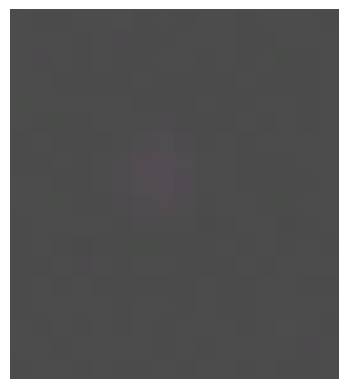

In [6]:
play_stimulus(stimulus[0].detach().cpu())

In the video you see that the stimulus that maximally activates this particular neuron first shows a green dot, and then switches to an UV dot. Let's visualize the same in a graphic. 

We plot a decomposition of the stimulus into a temporal trace (top left) and its spatial component (bottom left). On the right side we additionally plot the frequency components of the stimulus, and on the bottom the response of that neuron. We also see here that shortly before the interval the response is optimized for, the uv component of the stimulus strongly increases. In the spatial component you can see that the stimulus has a prominent center/surround structure, which you can observe in the video, too. 

Text(0.5, 0, 'Time [s]')

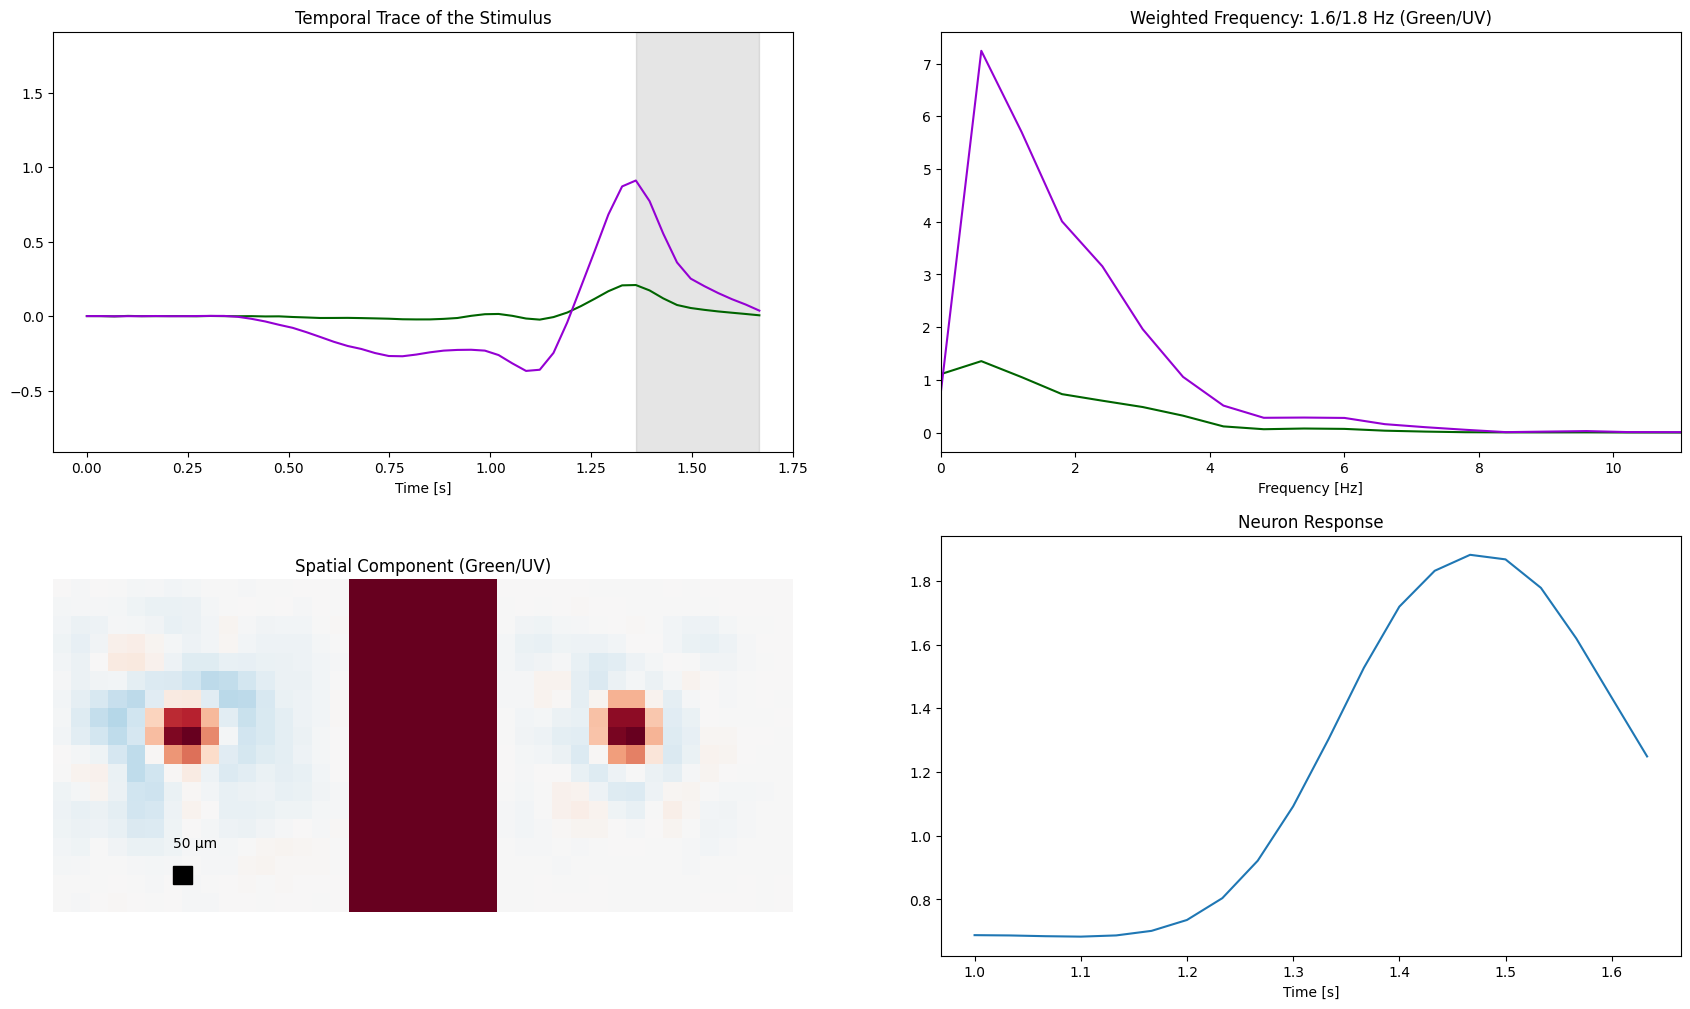

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(7 * 3, 12))
plot_stimulus_composition(
    stimulus=stimulus_np,
    temporal_trace_ax=axes[0, 0],
    freq_ax=axes[0, 1],
    spatial_ax=axes[1, 0],
    highlight_x_list=[(40, 49)],
)
neuron_trace = ensemble_model.forward(stimulus, data_key=session_id)[0, :, neuron_id].detach().cpu().numpy()
axes[1, 1].set_title("Neuron Response")
time_axis = np.arange(30, 30 + len(neuron_trace)) / 30.0
axes[1, 1].plot(time_axis, neuron_trace)
axes[1, 1].set_xlabel("Time [s]")

Now, let's implement our own simple objective. Instead of trying to increase the neuron response, we now want to decrease it.

To do this we inherit from the AbstractObjective class and implement the forward function ourselves. This function runs a forward path through the model, selects the response of the desired neuron, and then narrows the response to the frames 10 to 20. It than takes the mean of the remaining response, and negates this mean. So now the objective is to increase the negative response of that time interval, which is equivalent to minimizing the response.

In [8]:
class SingleNeuronMostDepressingObjective(AbstractObjective):
    def __init__(self, model, neuron_idx: int, data_key: str | None, response_reducer: ResponseReducer):
        super().__init__(model, data_key)
        self._neuron_idx = neuron_idx

    def forward(self, stimulus: torch.Tensor) -> torch.Tensor:
        responses = self.model_forward(stimulus)
        # responses.shape = (time, neuron)
        single_response = responses[:, self._neuron_idx]

        single_score = response_reducer.forward(single_response)
        negative_score = -single_score
        return negative_score


mdi_objective = SingleNeuronMostDepressingObjective(
    ensemble_model, neuron_idx=neuron_id, data_key=session_id,
    response_reducer=SliceMeanReducer(axis=0, start=10, length=10),
)

So let's initialize a new random stimulus and run optimization.

In [9]:
# initialize random stimulus with stdvar 0.1 clipped to range
mdi = torch.randn(stimulus_shape, requires_grad=True, device=device)
mdi.data = mdi.data * 0.1
stimulus.data = stimulus_postprocessor.process(mdi.data)

# optimize stimulus
optimize_stimulus(
    mdi,
    optimizer_init_fn,
    mdi_objective,
    OptimizationStopper(max_iterations=10),
    stimulus_postprocessor=stimulus_postprocessor,
    stimulus_regularization_loss=None,
)
mdi_np = mdi[0].detach().cpu().numpy()

Let's play the stimulus as a video, does it look different?

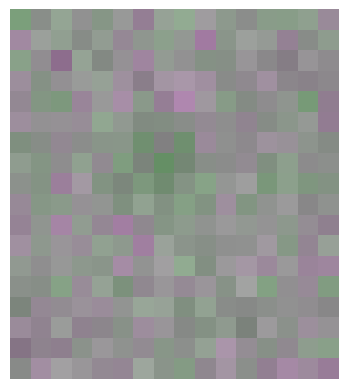

In [10]:
play_stimulus(mdi[0].detach().cpu())

As you can see in the video, the stimulus is way more noisy then the most exciting stimulus. This is reasonable, the neuron probably does not respond at all to most stimuli, including noisy stimuli. So the optimization found a specific noisy stimulus for which the activity of the neuron is low.
For a neuron type called suppressed-by-contrast cells, which decrease their activity below baseline rate for contrasts, the optimized stimulus would likely be less noisy (if you want to try this out, in session '3_ventral1_20201021' neuronid 100 is a suppressed-by-contrast cell).

Text(0.5, 0, 'Time [s]')

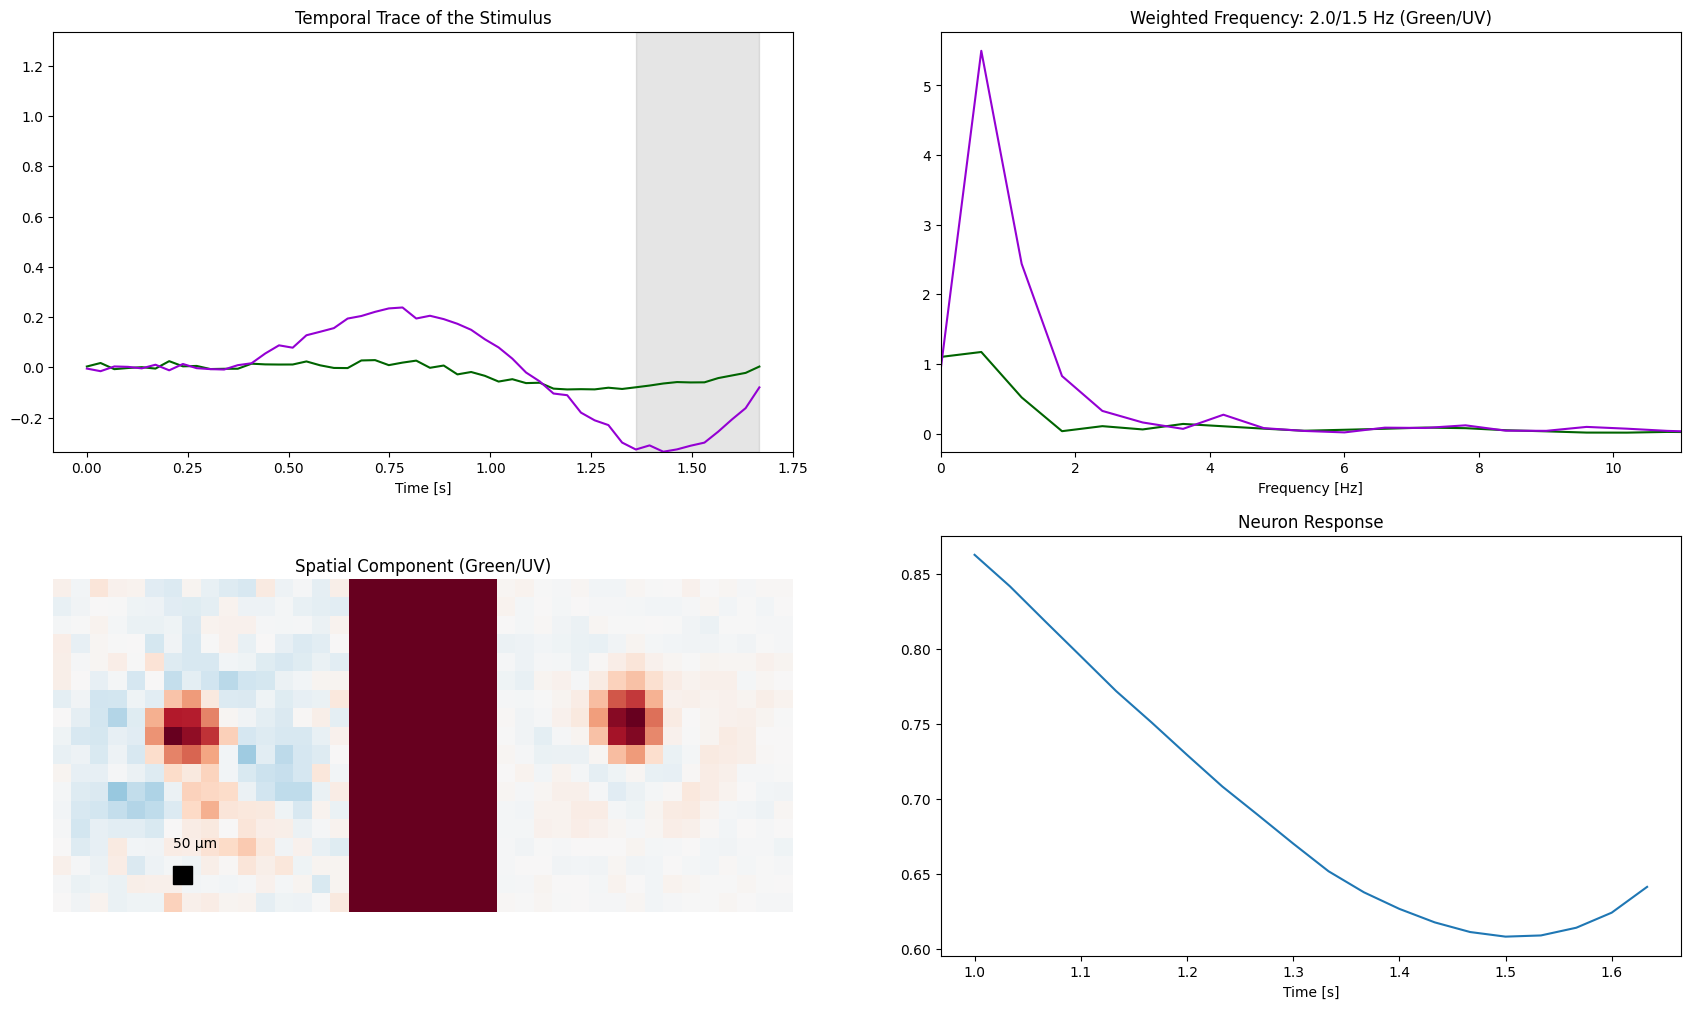

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(7 * 3, 12))
plot_stimulus_composition(
    stimulus=mdi_np,
    temporal_trace_ax=axes[0, 0],
    freq_ax=axes[0, 1],
    spatial_ax=axes[1, 0],
    highlight_x_list=[(40, 49)],
)
neuron_trace = ensemble_model.forward(mdi, data_key=session_id)[0, :, neuron_id].detach().cpu().numpy()
axes[1, 1].set_title("Neuron Response")
time_axis = np.arange(30, 30 + len(neuron_trace)) / 30.0
axes[1, 1].plot(time_axis, neuron_trace)
axes[1, 1].set_xlabel("Time [s]")

In principle, you can optimize any objective that you can write down in torch and that is differentiable.
Here is an objective that includes more neurons and tries to find a stimulus that leads to a strong response of one neuron and a weak response from all other neurons:

In [12]:
class SparseActivationOfFieldObjective(AbstractObjective):
    def __init__(self, model, data_key: str | None):
        super().__init__(model, data_key)

    def forward(self, stimulus: torch.Tensor) -> torch.Tensor:
        # responses.shape = (time, neuron)
        responses = self.model_forward(stimulus)
        # we do not use a response reducer here, but just take the mean of over the time dimension 
        mean_response = responses.mean(axis=0)
        max_response_neuron = responses.max()
        
        score = 2 * max_response_neuron - mean_response.sum() 
        return score


sparse_objective = SparseActivationOfFieldObjective(
    ensemble_model, data_key=session_id,
)

In [13]:
# initialize random stimulus with stdvar 0.1 clipped to range
sparse_stim = torch.randn(stimulus_shape, requires_grad=True, device=device)
sparse_stim.data = sparse_stim.data * 0.1
sparse_stim.data = stimulus_postprocessor.process(sparse_stim.data)

# optimize stimulus
optimize_stimulus(
    sparse_stim,
    optimizer_init_fn,
    sparse_objective,
    OptimizationStopper(max_iterations=50),
    stimulus_postprocessor=stimulus_postprocessor,
    stimulus_regularization_loss=None,
)
sparse_stim_np = sparse_stim[0].detach().cpu().numpy()

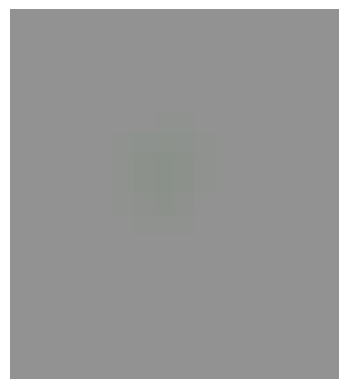

In [14]:
play_stimulus(sparse_stim[0].detach().cpu())

Text(0.5, 0, 'Time [s]')

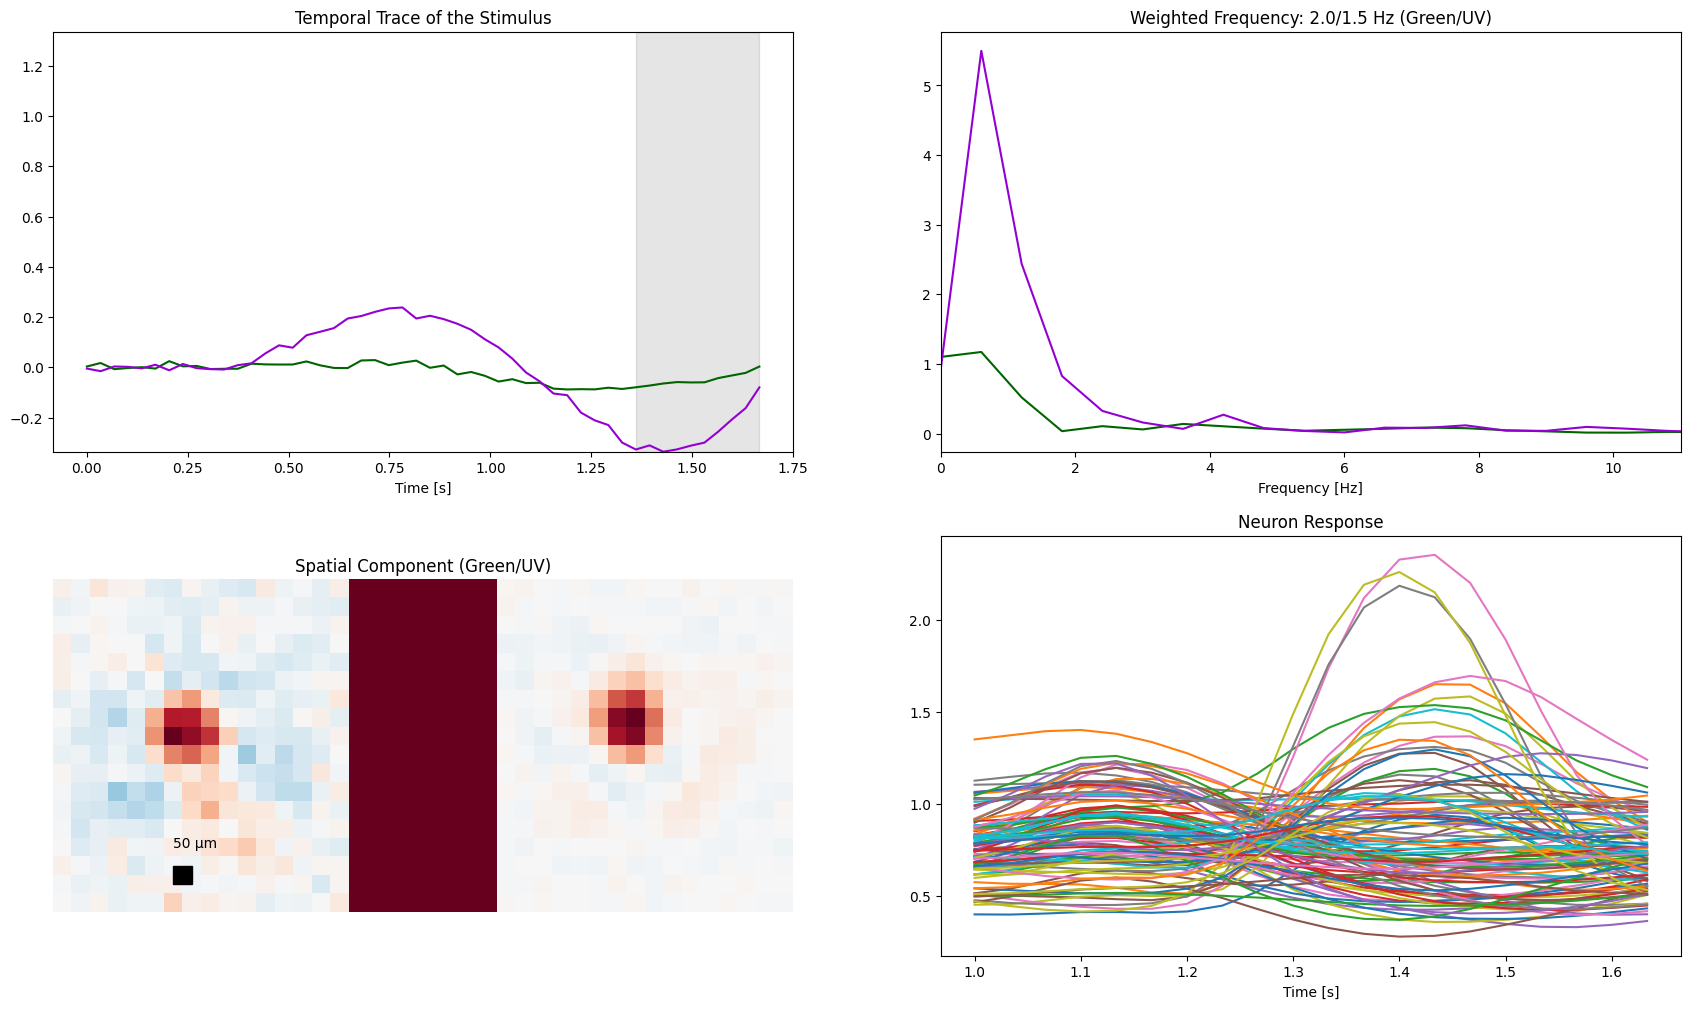

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(7 * 3, 12))
plot_stimulus_composition(
    stimulus=mdi_np,
    temporal_trace_ax=axes[0, 0],
    freq_ax=axes[0, 1],
    spatial_ax=axes[1, 0],
    highlight_x_list=[(40, 49)],
)
neuron_trace = ensemble_model.forward(sparse_stim, data_key=session_id)[0, :, :].detach().cpu().numpy()
axes[1, 1].set_title("Neuron Response")
time_axis = np.arange(30, 30 + len(neuron_trace)) / 30.0
for i in range(neuron_trace.shape[-1]):
    axes[1, 1].plot(time_axis, neuron_trace[:, i])
axes[1, 1].set_xlabel("Time [s]")

If you look at the neuron responses above, it partially worked, you see a trend that three neurons activate very strongly, and most of the remaining ones show a weak response.

If you want to read up on more involved optimization objective for stimuli, you can take a look at the following paper:
[Most discriminative stimuli for functional cell type clustering](https://openreview.net/forum?id=9W6KaAcYlr).